# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: The Search for New Earths

This project analyses the data observed by the NASA Kepler space telescope searching for exoplanets using the transit technique.  
planets themselves do not emit light, but the stars that they orbit do. If said star is watched over several months or years, there may be a regular 'dimming' of the flux (the light intensity). This is evidence that there may be an orbiting body around the star; such a star could be considered to be a 'candidate' system.
NASA itself utilises python to interpret the data and has created PyKE, a library for data reduction to help with extraction and preprocessing of the light curve images, however this project analyses only FLUX data, not pictures.
Some of the machine learning techniques already been used by developers are 1-D CNN, XGBoosting, PCA.

## Getting Started
importing dependencied and Loading the dataset

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import scipy
import matplotlib.patches as mpatches
from sklearn.metrics import fbeta_score, accuracy_score,make_scorer ,confusion_matrix, precision_score
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import normalize, MinMaxScaler
from pandas.tools.plotting import autocorrelation_plot
from sklearn import svm
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
from sklearn.model_selection import GridSearchCV, ShuffleSplit,train_test_split
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

import helper as hp
# Pretty display for notebooks
%matplotlib inline
print "Libraries imported successfully"

Libraries imported successfully


In [2]:
# Load the kepler training dataset
try:
    data = pd.read_csv(os.path.join("project_dataset", 'exoTrain.csv'),index_col=0)
    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

kepler dataset has 5087 samples with 3198 features each.


## Prepare data
the author of the database labelled with 1 no exoplanet system and 2 exoplanet system

In [3]:
#create label array and drop it from features
labels = data.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
labels.replace(1,0, inplace=True)
labels.replace(2,1, inplace=True)
data.drop('LABEL',axis=1, inplace =True)

In [21]:
# Display a description of the dataset
display(data[labels ==1].head())
display(data.describe())

,FLUX-1,FLUX-2,FLUX-3,FLUX-4,FLUX-5,FLUX-6,FLUX-7,FLUX-8,FLUX-9,FLUX-10,...,FLUX-3188,FLUX-3189,FLUX-3190,FLUX-3191,FLUX-3192,FLUX-3193,FLUX-3194,FLUX-3195,FLUX-3196,FLUX-3197
1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
3,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
4,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
5,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


,FLUX-1,FLUX-2,FLUX-3,FLUX-4,FLUX-5,FLUX-6,FLUX-7,FLUX-8,FLUX-9,FLUX-10,...,FLUX-3188,FLUX-3189,FLUX-3190,FLUX-3191,FLUX-3192,FLUX-3193,FLUX-3194,FLUX-3195,FLUX-3196,FLUX-3197
count,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,1.410852e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,1.942289e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,-2.223300e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,-2.797500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,-9.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,2.874500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,1.263870e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


#### normalisation
i will normalise the features by sample and apply min max scaler to reduce the size of numbers

In [15]:
scaler = MinMaxScaler(feature_range=(-10000,10000))
norm_data = normalize(data)
norm_data = scaler.fit_transform(norm_data)
norm_data = pd.DataFrame(norm_data, columns = data.keys(), index = data.index)
display(norm_data[labels ==1].head())

,FLUX-1,FLUX-2,FLUX-3,FLUX-4,FLUX-5,FLUX-6,FLUX-7,FLUX-8,FLUX-9,FLUX-10,...,FLUX-3188,FLUX-3189,FLUX-3190,FLUX-3191,FLUX-3192,FLUX-3193,FLUX-3194,FLUX-3195,FLUX-3196,FLUX-3197
1,-2886.956774,-4983.919275,-5426.179656,-2877.350780,67.109860,-5255.898403,-5431.643877,-3593.582985,-6516.247191,-4533.417575,...,-6561.778106,-4219.899022,-1416.437585,-3241.000630,-7639.236330,-220.090422,-6444.010520,-7792.788659,-5214.096650,2630.962101
2,-3480.335105,-5387.056738,-5798.144722,-3194.249437,-987.659462,-5478.442820,-5745.929780,-4228.187269,-6920.909957,-4701.421470,...,-6284.231172,-4107.278586,-1253.509004,-3821.690413,-7763.947200,-810.463401,-6699.937561,-7898.573113,-5022.645560,3251.121997
3,-2254.716761,-4468.745860,-4848.635213,-1643.066473,1911.909021,-3998.873413,-4111.237469,-1781.315840,-5589.441133,-2451.649423,...,-6413.144572,-3464.890101,-324.162190,-3509.058567,-7761.881250,-804.817722,-6611.261802,-7979.229523,-5443.989813,2526.072492
4,-1639.562874,-3923.317881,-4472.924480,-924.960781,3352.642550,-3287.559389,-3329.689637,-776.667711,-4920.695272,-1368.701247,...,-6213.647541,-3557.163247,-457.654237,-3103.182864,-7674.427692,-952.435849,-6636.417461,-8004.264563,-5377.929511,3041.593726
5,-4484.808493,-6197.770991,-6403.500409,-4489.642661,-2258.684748,-6170.071858,-6287.226199,-5085.997548,-7392.663553,-5599.242647,...,-7189.802037,-4609.468084,-1980.029204,-4297.692249,-8093.356529,-1954.358425,-7160.564512,-8303.513481,-6070.418154,1544.327872


### visualization of luminosity on time series
#### note
some system have strong drops in luminescence, this systems must have a big or close planet orbiting it, this makes this type of system easier to diferenciate from the non exo-systems, i will analyse more in details the ones where there is less clarity.

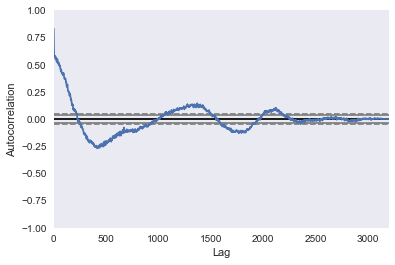

In [34]:
autocorrelation_plot(data.loc[37])

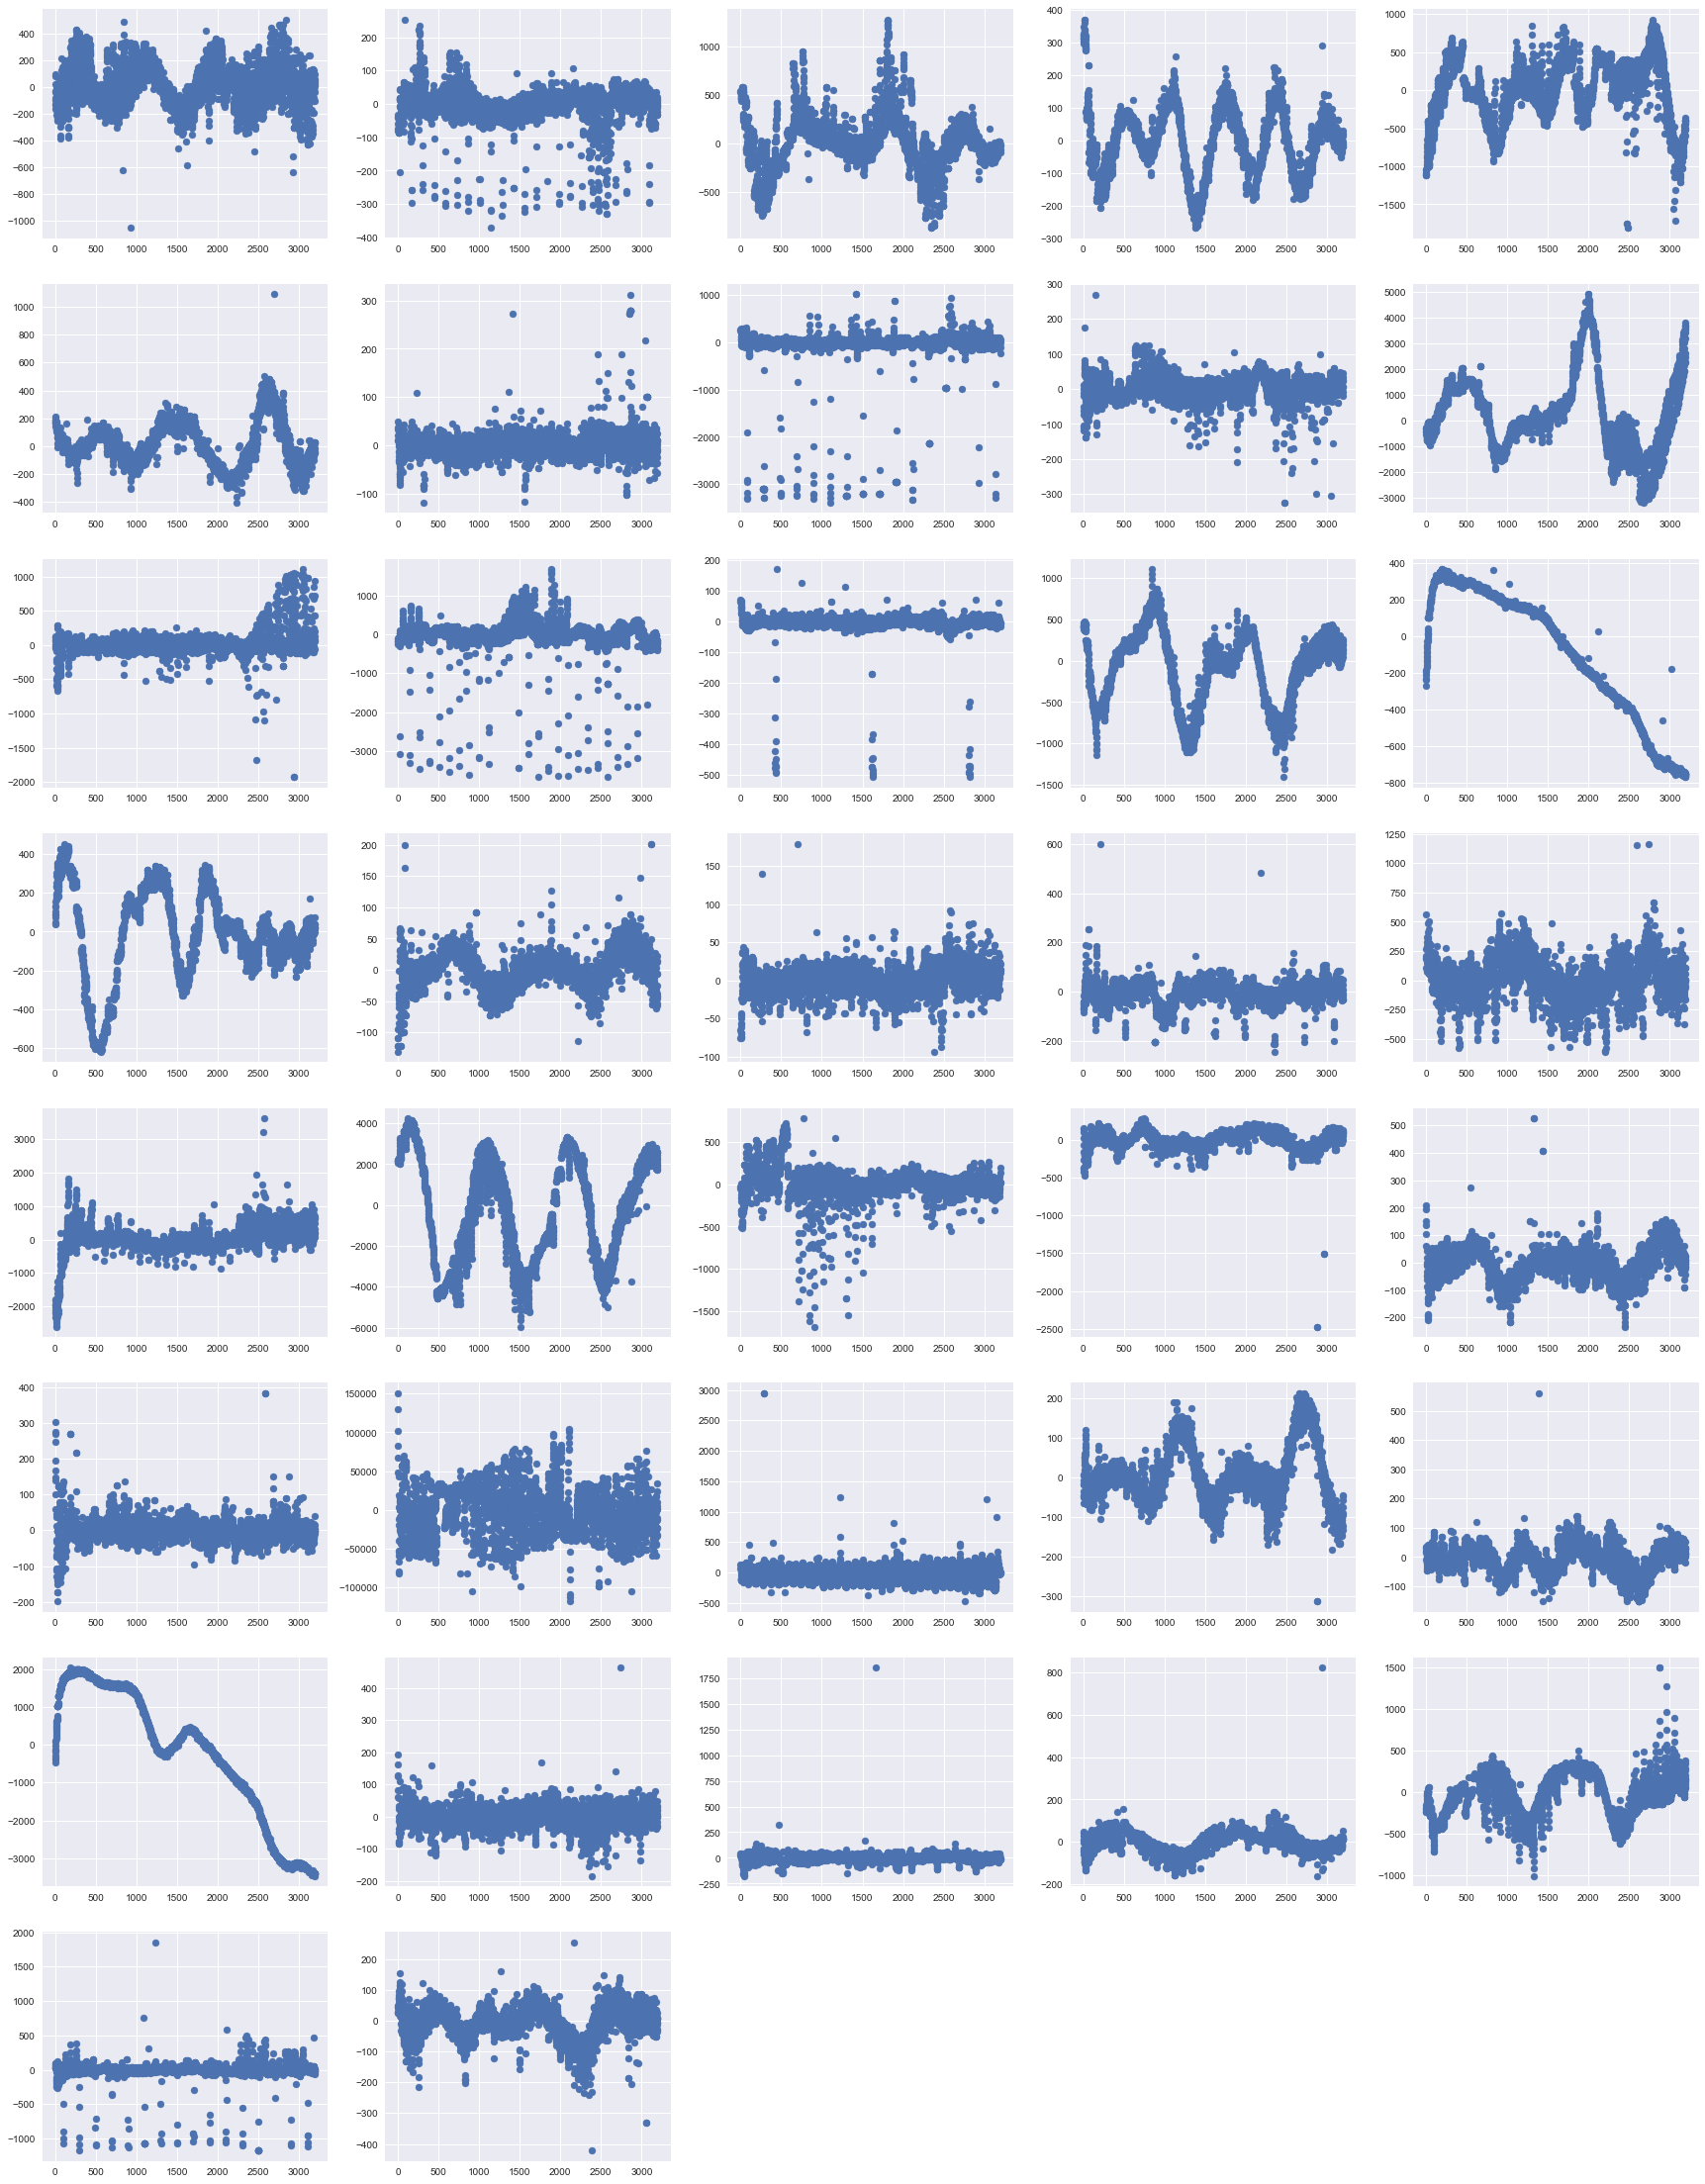

In [28]:
fig = plt.figure(figsize=(30,40))
x = np.array(range(3197))
for i in range(37):
    ax = fig.add_subplot(8,5,i+1)
    ax.scatter(x,data.iloc[i,:])

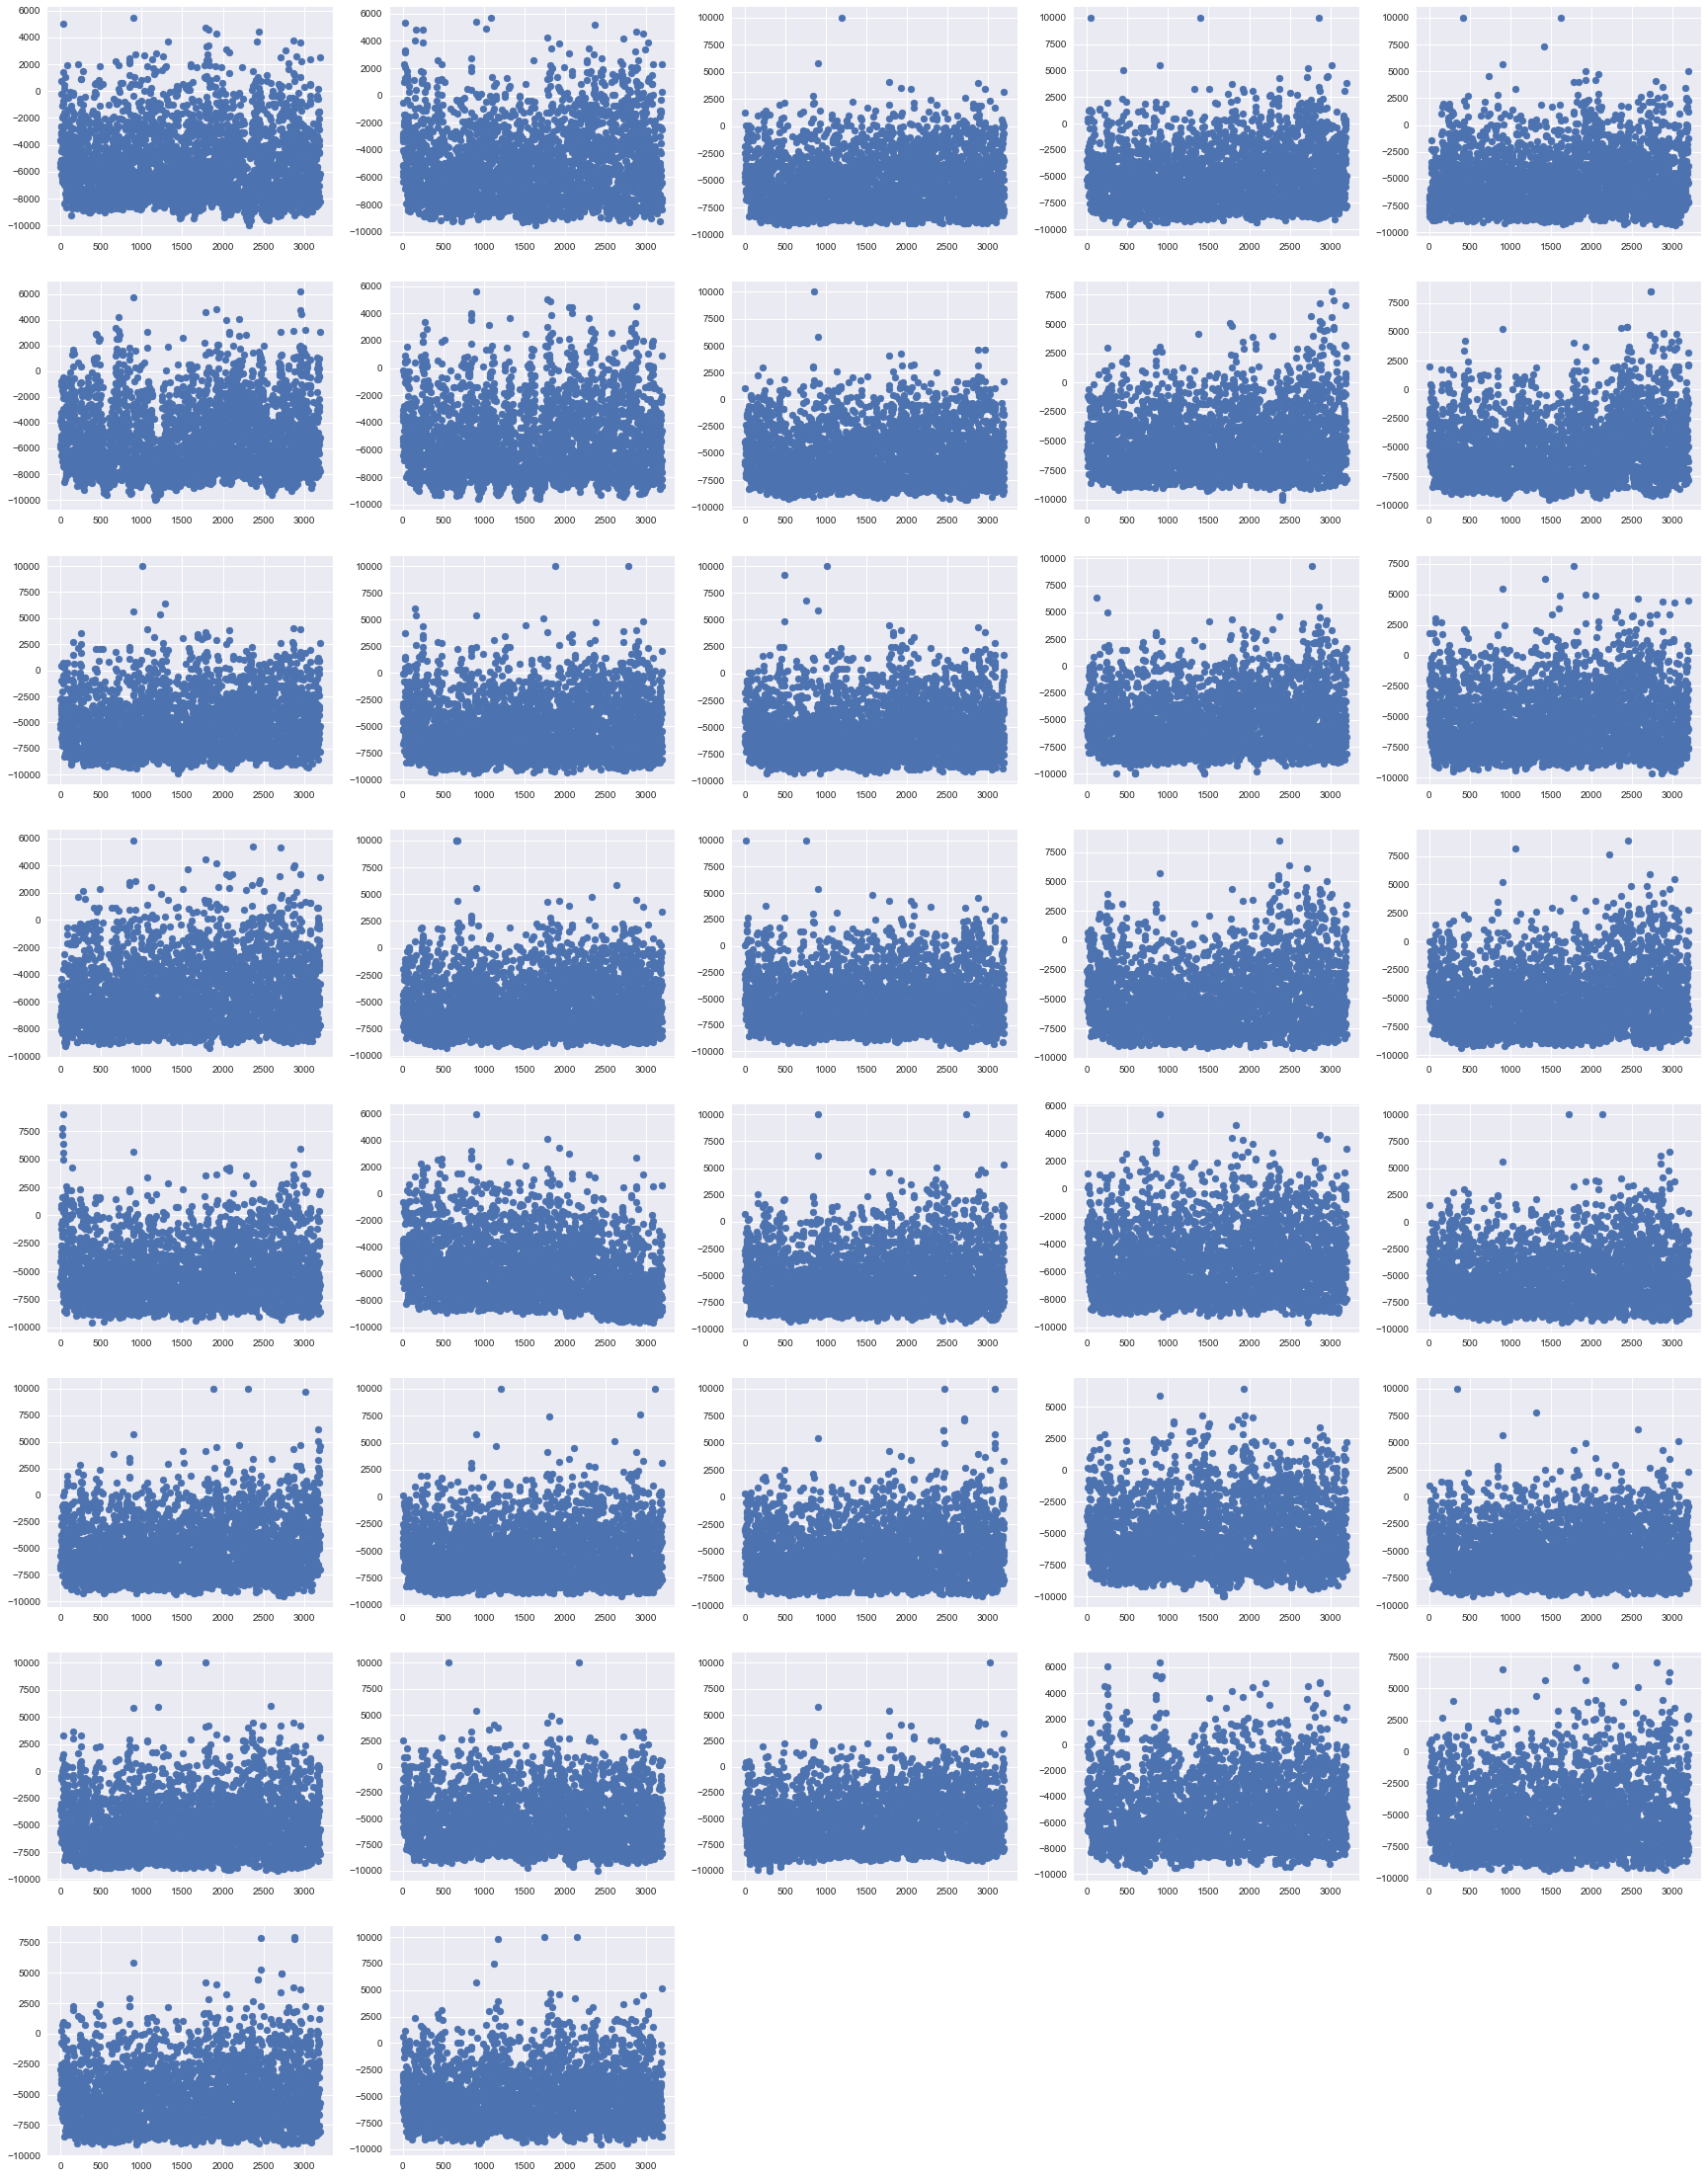

In [36]:
#look for outliers on class 0 because if in class 1 it's valuable information
cnt = hp.find_outliers(norm_data[labels == 0])
outliers = list(cnt.most_common(37))
fig = plt.figure(figsize=(30,40))
x = np.array(range(3197))
for i in range(37):
    outliers[i] = outliers[i][0]
    ax = fig.add_subplot(8,5,i+1)
    ax.scatter(x,data.iloc[outliers[i],:])

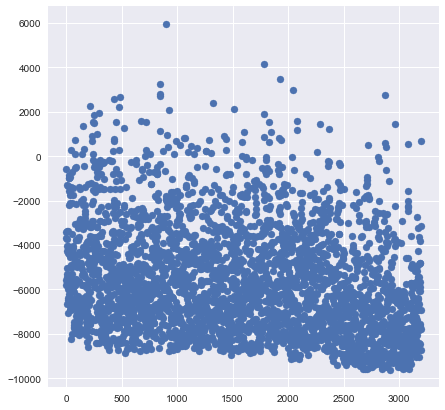

In [37]:
#special outlier
fig , ax = plt.subplots(figsize=(7,7))
ax.scatter(x,data.iloc[outliers[21],:])

In [38]:
#remove the 1% outliers
OnePer = int(len(data['FLUX-1'])/100)
print "removed 1% of the outliers which is: {} ".format(OnePer)
outliers = list(cnt.most_common(OnePer))
for i in range(OnePer):
    outliers[i] = outliers[i][0]
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
good_labels = labels.drop(labels.index[outliers]).reset_index(drop = True)

removed 1% of the outliers which is: 50 


### checkpoint
save data for one class outlier classification

In [12]:
#save data
pickle.dump((good_data, good_labels), open('OneClass-Train.p', 'wb'))

## class imbalance correction
at this point we are ready to apply correction for class imbalance

using Tomek link for undersampling as final solution

In [13]:
smote = SMOTE(n_jobs =-1,kind = 'svm',k_neighbors = 10,m_neighbors =15, random_state=42)
over_data, over_labels = smote.fit_sample(good_data,good_labels)

In [14]:
TL = TomekLinks(n_jobs =-1,random_state=42)
under_data, under_labels = TL.fit_sample(over_data,over_labels)

helper.py:90: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  c0 = ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0",
helper.py:92: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  c1 = ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1",


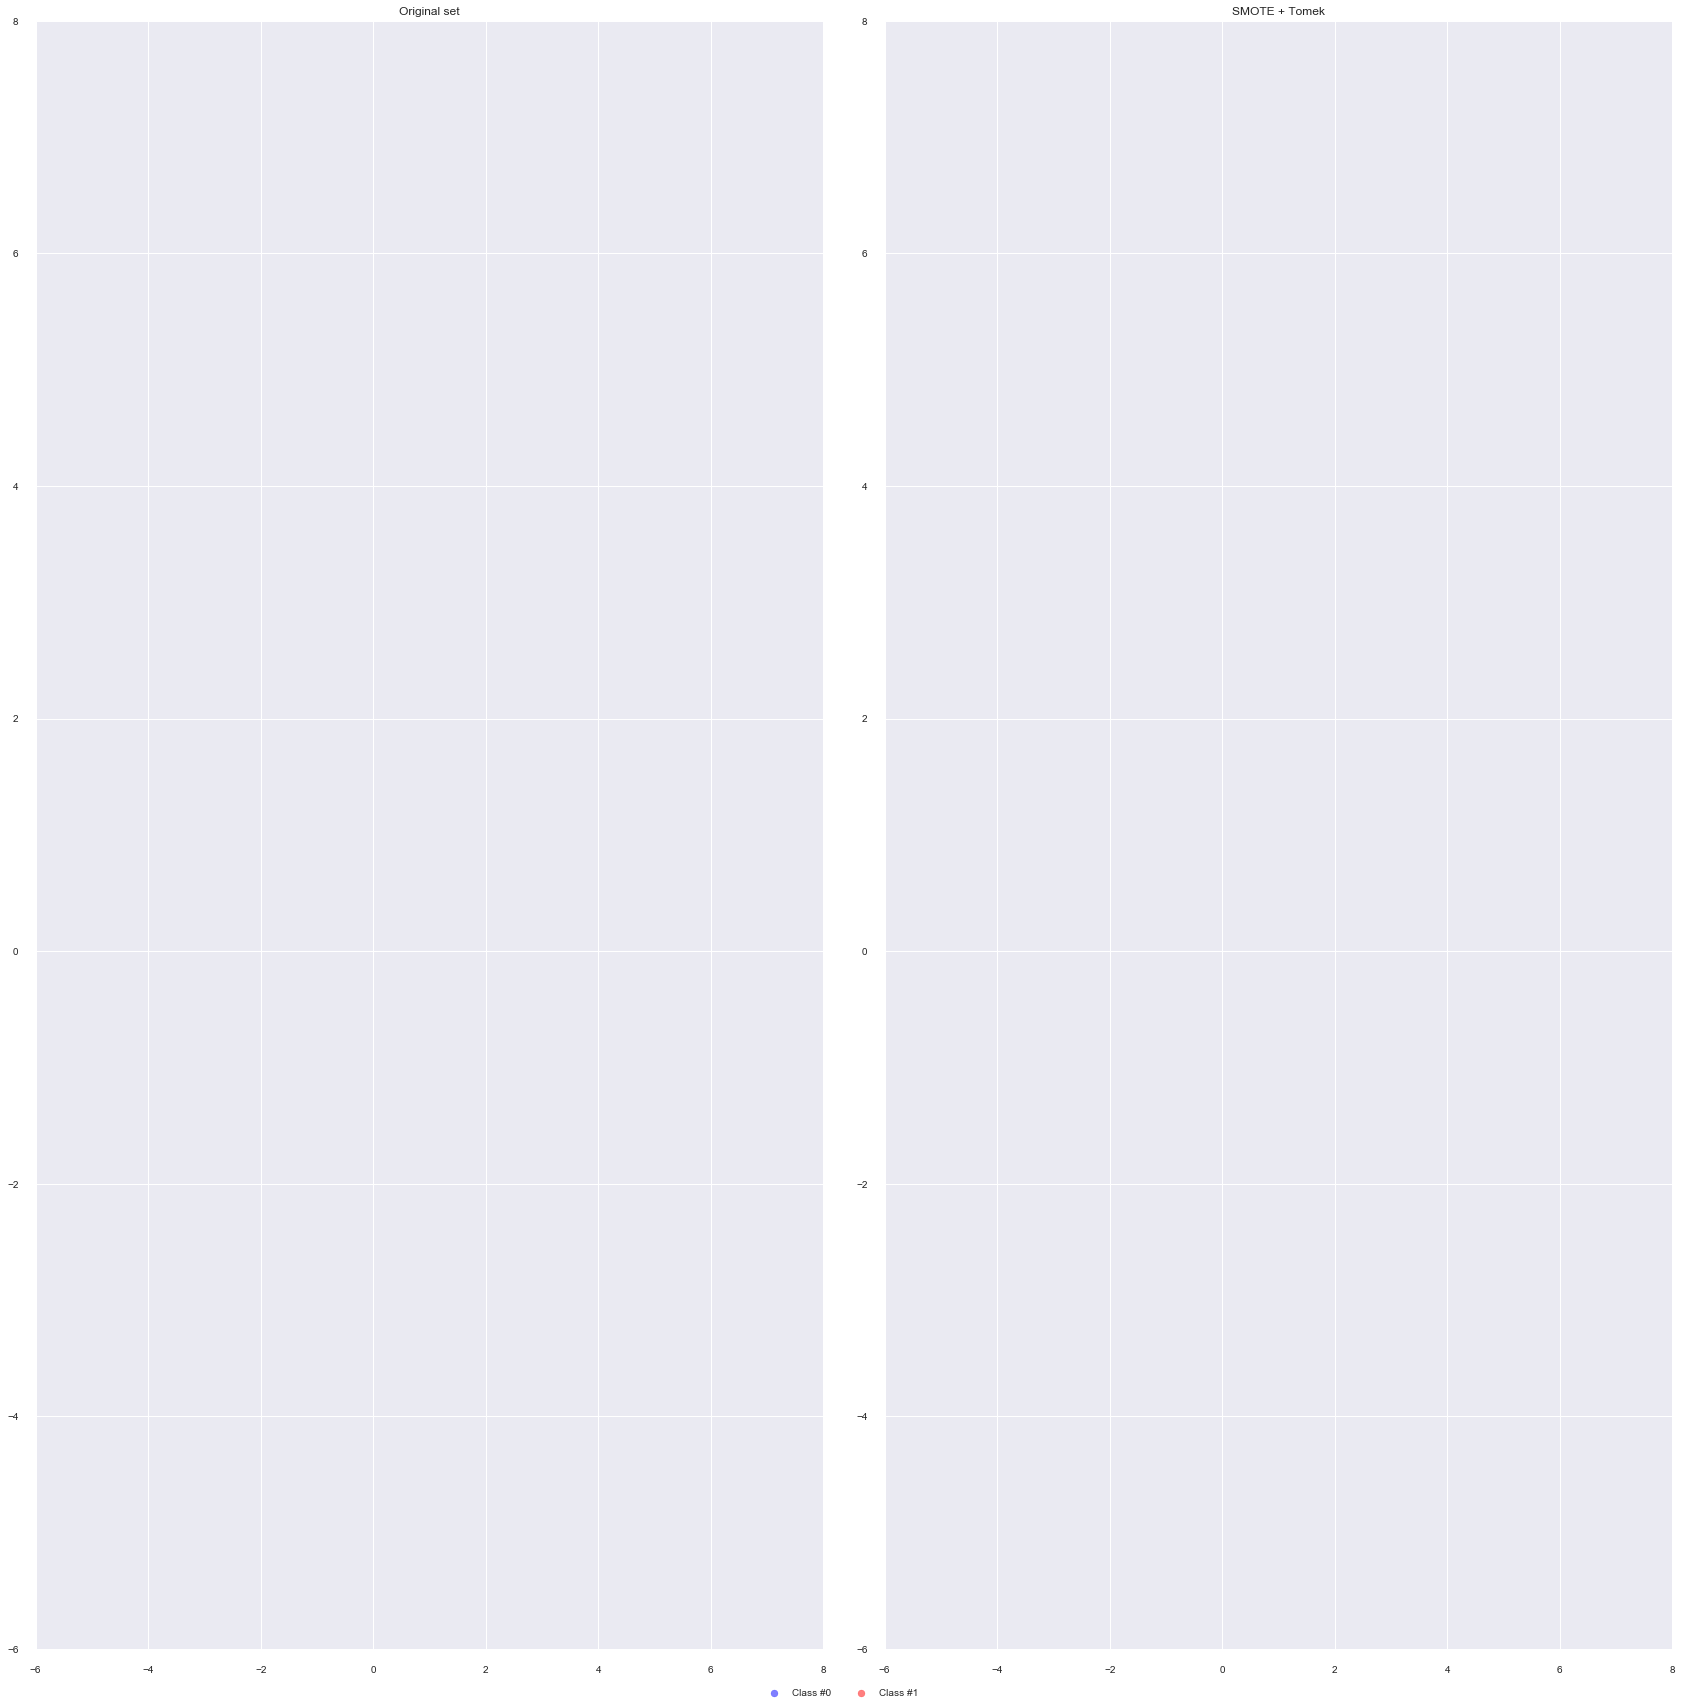

In [15]:
hp.vs_class_imbalance(good_data, good_labels,under_data, under_labels)

### checkpoint
save data for one class outlier classification

In [16]:
#save data
pickle.dump((under_data, under_labels), open('Classifier-Train.p', 'wb'))

## One Class implementation Begin
for one class i use the full training set for class 0 without the outliers

In [29]:
# Load the Preprocessed data
good_data, good_labels = pickle.load(open('OneClass-Train.p', mode='rb'))

In [17]:
def mod_clas(y_pred):
    y_pred = [0 if i == -1 else 1 for i in y_pred]
    return y_pred

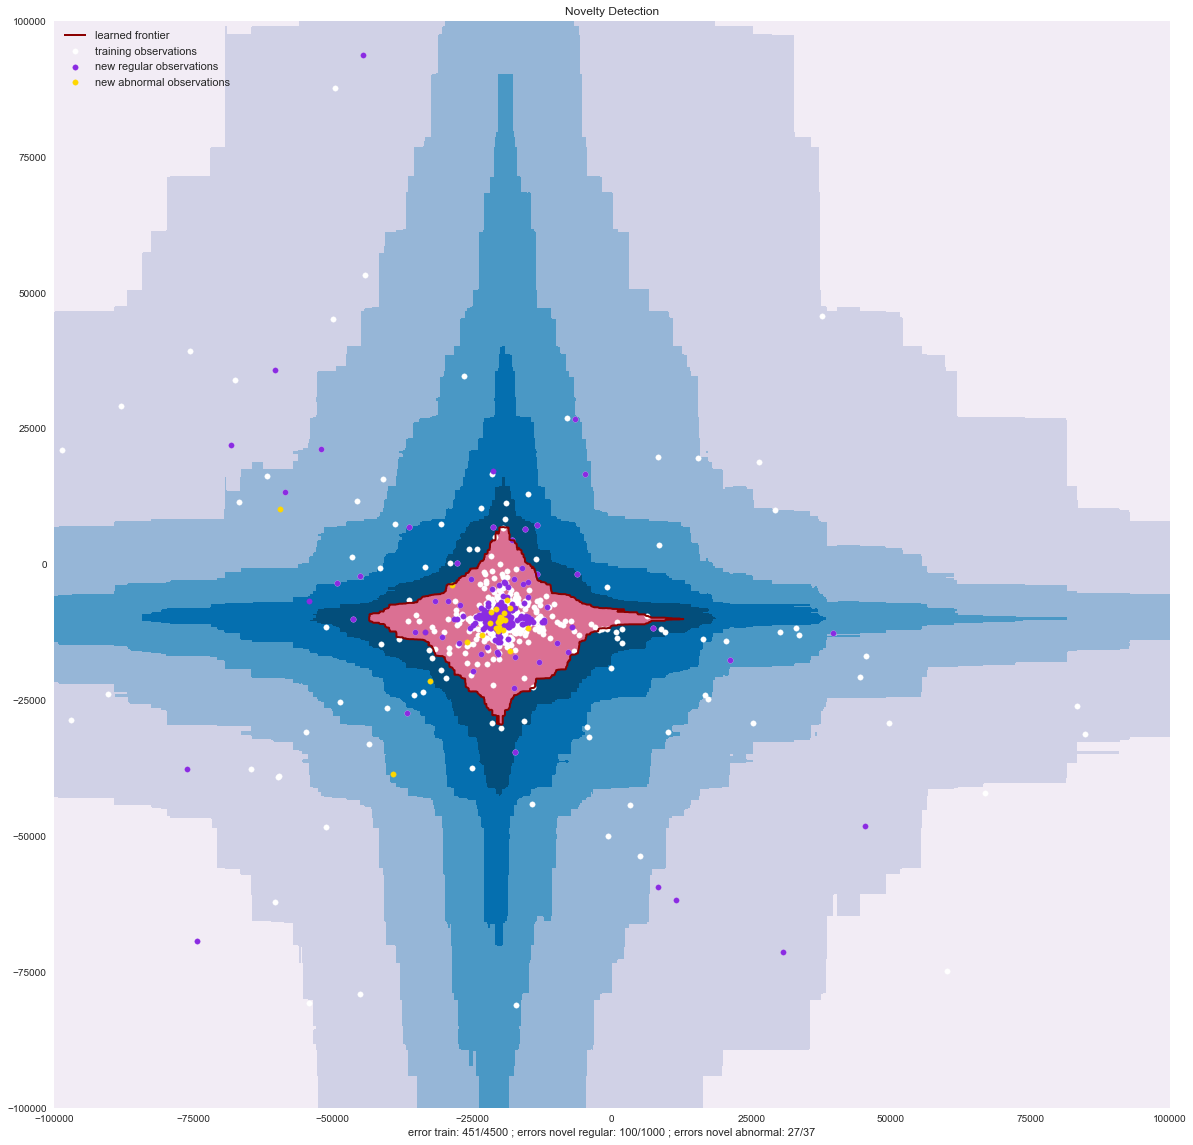

In [44]:
def vs_frontiers(good_data,good_lables):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.font_manager
    pca = PCA(n_components=2, random_state = 42)
    xx, yy = np.meshgrid(np.linspace(-100000,100000, 1000), np.linspace(-100000,100000, 1000))

    X_train = pca.fit_transform(good_data[good_lables == 0].sample(4500))
    X_test = pca.transform(good_data[good_lables == 0].sample(1000))
    X_outliers = pca.transform(good_data[good_lables == 1])

    # fit the model
    clf = IsolationForest(n_jobs = -1,random_state =42).fit(X_train)
    #predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers =clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

    # plot the line, the points, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,20))
    plt.title("Novelty Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    s = 30
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
    #d = plt.scatter(X_TrainOUTliers[:, 0], X_TrainOUTliers[:, 1], c='red', s=s)
    plt.axis('tight')
    plt.xlim((-100000, 100000))
    plt.ylim((-100000, 100000))
    plt.legend([a.collections[0], b1, b2, c],
               ["learned frontier", "training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.xlabel(
        "error train: %d/4500 ; errors novel regular: %d/1000 ; "
        "errors novel abnormal: %d/37"
        % (n_error_train, n_error_test, n_error_outliers))
    plt.show()
vs_frontiers(good_data,good_labels)

In [90]:
#testing performance against benchmark no pca
onesvm = svm.OneClassSVM(random_state =42)
onesvm.fit(good_data[good_labels == 0])
y_pred = onesvm.predict(good_data)

y_pred = [0 if i == -1 else 1 for i in y_pred]

st, sp, su = sensitivity_specificity_support(good_labels,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)

sensitivity: [ 0.893  0.   ], specitivity: [ 0.     0.893], support : [5000   37]


In [92]:
pca = PCA(n_components = 46, random_state = 42)
PCA_train = pca.fit_transform(good_data[good_labels == 0])
PCA_data = pca.transform(good_data)
onesvm.fit(PCA_train)
y_pred = clf.predict(PCA_data)

y_pred = [0 if i == -1 else 1 for i in y_pred]

st, sp, su = sensitivity_specificity_support(good_labels,y_pred)
print 'benchmark : sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
# build the pipeline
Ifo = IsolationForest(n_jobs = -1,random_state =42)

ifo = ifo.fit(PCA_train)

y_pred = ifo.predict(PCA_data)

st, sp, su = sensitivity_specificity_support(good_labels,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
print classification_report_imbalanced(good_labels, y_pred)

benchmark : sensitivity: [ 0.9998  0.    ], specitivity: [ 0.      0.9998], support : [5000   37]


TypeError: All intermediate steps should be transformers and implement fit and transform. 'IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=42,
        verbose=0)' (type <class 'sklearn.ensemble.iforest.IsolationForest'>) doesn't

## One Class Implementation End

## Classifier begin


In [9]:
# Load the Preprocessed data
under_data, under_labels = pickle.load(open('Classifier-Train.p', mode='rb'))

In [10]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(under_data, under_labels,stratify =under_labels,
                                                    test_size=0.4, random_state=42)

## Feature Transformation
### application of PCA looking for best number of features and tuning the classifier of choice

In [74]:
def fit_model(X, y):
    pca = PCA(random_state = 42)
    score = make_scorer(precision_score)
    gbc = GradientBoostingClassifier(n_estimators = 100, max_depth= 7,min_impurity_split= 100000.0,random_state = 42)
    Pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', gbc)])
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 5,test_size = 0.20, random_state = 42)

    #params dictionary for grid search
    ##tests made:
    ##learning_rate: (0.1,0.08,0.01,0.5)n_estimators:(50,100,180,200,250)max_depth(3,4,5,6,7,8,10)
    params = {'reduce_dim__n_components':(40,45,46)}

    #scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(precision_score)

    #Create the grid search object
    grid = GridSearchCV(Pipe,params,scoring = scoring_fnc,cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [75]:
model = fit_model(under_data, under_labels)

In [76]:
print model.named_steps['reduce_dim'].n_components_

46


## classifier comparison and tuning

GaussianNB trained on 931 samples.
GaussianNB trained on 1863 samples.
GaussianNB trained on 4659 samples.
SVC trained on 931 samples.
SVC trained on 1863 samples.
SVC trained on 4659 samples.
GradientBoostingClassifier trained on 931 samples.
GradientBoostingClassifier trained on 1863 samples.
GradientBoostingClassifier trained on 4659 samples.


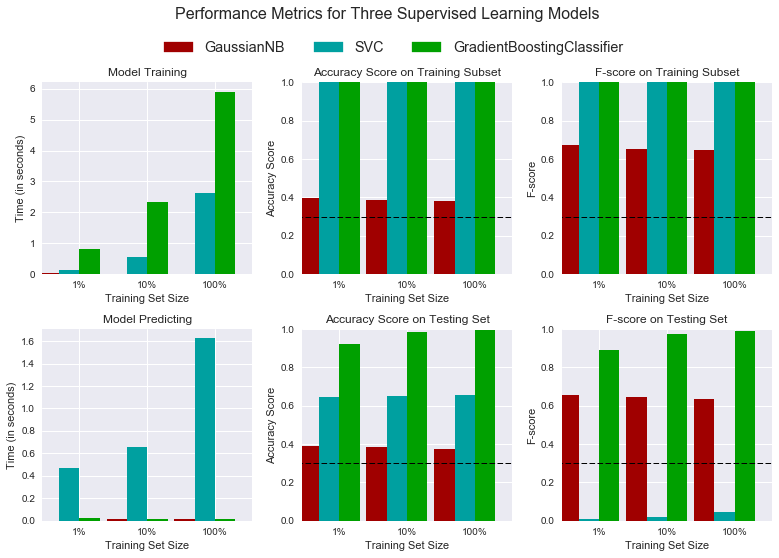

In [11]:
pca = PCA (n_components = 46, random_state = 42)
X_trainPCA = pca.fit_transform(X_train)
X_valPCA =  pca.transform(X_val)

#Initialize the three models
clf_A = GaussianNB()
clf_B = SVC()
clf_C = GradientBoostingClassifier(n_estimators = 100, max_depth= 7,min_impurity_split= 100000.0,random_state = 42)
tot_training = X_trainPCA.shape[0]

#Calculate the number of samples for 1%, 10%,100% of the training data
samples_1 =   int(tot_training * 0.2)
samples_10 =  int(tot_training * 0.4)
samples_100 = int(tot_training * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        hp.train_predict(clf, samples, X_trainPCA, y_train, X_valPCA, y_val)

# Run metrics visualization for the three supervised learning models chosen
hp.evaluate(results, 0.6, 0.6)

In [79]:
#standard gradient boosting
y_pred = clf_C.predict(X_valPCA)
print classification_report_imbalanced(y_val, y_pred)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.99      1.00      1.00      0.99      2000
          1       1.00      0.99      1.00      0.99      1.00      0.99      1107

avg / total       1.00      1.00      0.99      1.00      1.00      0.99      3107



In [81]:
#optimised gradient boosting
y_pred = model.predict(X_val)
print classification_report_imbalanced(y_val, y_pred)

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      2000
          1       1.00      1.00      1.00      1.00      1.00      1.00      1107

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      3107



## loading testing data
now load the test data and test on the classifier.

In [12]:
# Load the kepler dataset
Testdata = pd.read_csv(os.path.join("project_dataset", 'exoTest.csv'),index_col=0)

In [13]:
#create label array and drop it from features
testlabels = Testdata.LABEL

testlabels.replace(1,0, inplace=True)
testlabels.replace(2,1, inplace=True)
Testdata.drop('LABEL',axis=1, inplace =True)

## evaluation of the result using Classifier

In [18]:
X_testdata = scaler.transform(normalize(Testdata))
y_pred = model.predict(X_testdata)
print classification_report_imbalanced(testlabels, y_pred)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.00      1.00      0.00      0.00       565
          1       0.00      0.00      1.00      0.00      0.00      0.00         5

avg / total       0.98      0.99      0.01      0.99      0.00      0.00       570



C:\Users\andre\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda2\lib\site-packages\imblearn\metrics\classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
C:\Users\andre\Anaconda2\lib\site-packages\imblearn\metrics\classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


## evaluation of the result using One class outlier detection

In [94]:
x_testdata = pca.transform(Testdata)

y_pred = ifo.predict(x_testdata)
y_pred = [0 if i == -1 else 1 for i in y_pred]
st, sp, su = sensitivity_specificity_support(testlabels,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
print
print classification_report_imbalanced(testlabels, y_pred)
print confusion_matrix(testlabels, y_pred)

sensitivity: [ 0.09734513  0.8       ], specitivity: [ 0.8         0.09734513], support : [565   5]

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.10      0.80      0.18      0.09      0.01       565
          1       0.01      0.80      0.10      0.02      0.09      0.01         5

avg / total       0.97      0.10      0.79      0.18      0.09      0.01       570

[[ 55 510]
 [  1   4]]
